### First read data from the disk

In [ ]:
import pandas as pd
import numpy as np
import cv2
import copy

directory = 'training_data1'
df = pd.read_csv('./'+directory+'/driving_log.csv')
df.columns = ['center','left','right','steering','throttle','brake','speed']


df_non_zero_steering = df.loc[lambda df: df.steering != 0, :].copy()
df_non_zero_steering = df_non_zero_steering.reset_index(drop = True)
nb_training_data = df_non_zero_steering.center.shape[0]
print (nb_training_data)

X_training =  np.zeros([nb_training_data, 160,320,3 ], dtype=np.uint8)
X_training_left =  np.zeros([nb_training_data, 160,320,3 ], dtype=np.uint8)
X_training_right =  np.zeros([nb_training_data, 160,320,3 ], dtype=np.uint8)


# gathering data from center camera
index = 0
for line in range(nb_training_data):
    # for center camera
    source_path = df_non_zero_steering.center[line]
    filename = source_path.split('/')[-1]
    current_path = './'+directory+'/IMG/'+filename
    image = cv2.imread(current_path, cv2.IMREAD_COLOR)
    X_training[index] = image

    # for left camera
    left_cam_path = df_non_zero_steering.left[line]
    filename = left_cam_path.split('/')[-1]
    current_path = './'+directory+'/IMG/'+filename
    image = cv2.imread(current_path, cv2.IMREAD_COLOR)
    X_training_left[index] = image
    
    # for right camera
    right_cam_path = df_non_zero_steering.right[line]
    filename = right_cam_path.split('/')[-1]
    current_path = './'+directory+'/IMG/'+filename
    image = cv2.imread(current_path, cv2.IMREAD_COLOR)
    X_training_right[index] = image

    # increase index
    index+=1

    
# read label from df
lable_y = df_non_zero_steering.as_matrix(columns=['steering'])
y_train = lable_y[:,0]

# add a shift manaully
y_train_left = np.copy(y_train)
y_train_left = y_train_left + 0.1
y_train_right = np.copy(y_train)
y_train_right = y_train_right - 0.1
# 

X_train_initial_aug =  np.vstack( (X_training,X_training_left, X_training_right) )
y_train_initial_aug =  np.concatenate( (y_train, y_train_left, y_train_right ) )




In [ ]:
len(df)

training n %d 16620
validation n %d 4210


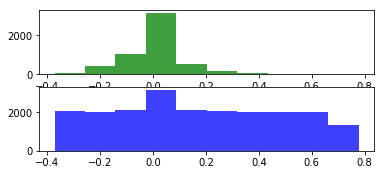

In [16]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import copy
%matplotlib inline

directory = 'training_data1'
df = pd.read_csv('./'+directory+'/driving_log.csv')
df.columns = ['center','left','right','steering','throttle','brake','speed']

steering_cmds = df.as_matrix(columns=['steering'])
steering_data = steering_cmds[:,0]

plt.subplot(3, 1, 1)

n, bins, patches = plt.hist(steering_data, 10, facecolor='green', alpha=0.75)
#print (bins)
#print (n)
df_merge = df
for i in range(len(bins)-1):
    df_sub = df.loc[lambda df: (df.steering >= bins[i]) , :].copy()
    df_sub_ =  df_sub.loc[lambda df: (df.steering < bins[i+1]) , :].copy()
    data_frames = [df_merge, df_sub_]   
    duplicate = 2000/n[i]
    # print duplicate
    for j in range( int(duplicate) ):
        df_merge = pd.concat(data_frames, ignore_index=True)
        data_frames = [df_merge, df_sub_]
steering_cmds = df_merge.as_matrix(columns=['steering'])
steering_data = steering_cmds[:,0]
plt.subplot(3, 1, 2)
n, bins, patches = plt.hist(steering_data, 10, facecolor='blue', alpha=0.75)    

# split df_merge into training and validation set
msk = np.random.rand(len(df_merge)) < 0.8
train_samples = df_merge[msk]
validation_samples = df_merge[~msk]
print ('training n %d', len(train_samples))
print ('validation n %d', len(validation_samples))


In [15]:
samples = train_samples
num_samples = len(samples)
batch_size = 32
print (num_samples)
df_batch_samples = samples[0:64]
df_batch_samples.reset_index(drop=True)
df_batch_samples
for row_index, series in df_batch_samples.iterrows():
    pass

#for offset in range(0, num_samples, batch_size):
#    pass
#for offset in range(0, num_samples, batch_size):
#    df_batch_samples = samples[offset:offset+batch_size]
#    for row_index, series in df_batch_samples:
#                name = './IMG/'+series.center.split('/')[-1]


16785


In [27]:
import cv2
import numpy as np
import sklearn

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        # shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            df_batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for row_index, series in df_batch_samples.iterrows():
                name = './'+directory+'/IMG/'+series.center.split('/')[-1]
                #urrent_path = './'+directory+'/IMG/'+filename
                center_image = cv2.imread(name)
                center_angle = float(series.steering)
                images.append(center_image)
                angles.append(center_angle)
            
                left_name = './'+directory+'/IMG/'+series.left.split('/')[-1]
                left_image = cv2.imread(left_name)
                left_angle = float(series.steering) + 0.1
                images.append(left_image)
                angles.append(left_angle)
                
                right_name = './'+directory+'/IMG/'+series.right.split('/')[-1]
                right_image = cv2.imread(right_name)
                right_angle = float(series.steering) - 0.1
                images.append(right_image)
                angles.append(right_angle)
                
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
           
            yield sklearn.utils.shuffle(X_train, y_train)
            #return sklearn.utils.shuffle(X_train, y_train)


            
# compile and train the model using the generator function

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)



### Visualize training data

(96, 160, 320, 3)
(96,)


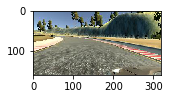

In [25]:
import matplotlib.pyplot as plt
import random
%matplotlib inline

(X_training, y_train) =  next(train_generator)

random_image = random.randint(0 , X_training.shape[0])   
#plt.figure( figsize =(100,100))
plt.subplot(3, 1, 1)
plt.imshow( cv2.cvtColor(X_training[random_image], cv2.COLOR_BGR2RGB) )
#plt.subplot(3, 1, 2)
#plt.imshow( cv2.cvtColor(X_training_left[random_image], cv2.COLOR_BGR2RGB) )
#plt.subplot(3, 1, 3)
#plt.imshow( cv2.cvtColor(X_training_right[random_image], cv2.COLOR_BGR2RGB) )


In [ ]:
## use left and right image to train on non zero datas 
df.loc[lambda df: df.steering != 0, :]



### Data augmentation

In [ ]:
X_training_flip = np.zeros([y_train_initial_aug.shape[0], 160 , 320 , 3 ], dtype=np.uint8)
for i in range(y_train_initial_aug.shape[0]):
    X_training_flip[i] =  np.fliplr(X_train_initial_aug[i])
y_train_flip = -y_train_initial_aug


In [ ]:
y_train.shape

In [ ]:
# stack training data
X_training =  np.vstack( (X_train_initial_aug,X_training_flip) )
y_train =  np.concatenate( (y_train_initial_aug, y_train_flip))

In [ ]:
df

In [28]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense , Lambda, MaxPooling2D, Dropout,Cropping2D

i_shape = (160, 320,3)

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=i_shape ))
model.add(Cropping2D(cropping=((60,25), (0,0)), input_shape=(160,320,3)))

# conv_net
model.add(Conv2D( 6, 5, 5, activation='relu' ))
model.add(Conv2D( 6, 5, 5,  activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
########################################################################
# conv_net
model.add(Conv2D(16, 3, 3, activation='relu'))
model.add(Conv2D(16, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#########################################################################
model.add(Flatten())
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(84, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam')
#model.fit(X_training, y_train, validation_split = 0.2, shuffle=True)
model.fit_generator(train_generator, samples_per_epoch= 3*len(train_samples), validation_data=validation_generator, nb_val_samples=3*len(validation_samples), nb_epoch=5)
model.save('first_model.h5')




Epoch 1/5
  384/49860 [..............................] - ETA: 3476s - loss: 0.1031

KeyboardInterrupt: 